In this notebook, we will write a code to gather velocity data from all the drives we have done so far.

In [11]:
from strym import strymread
import strym
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import time
import pickle

# Set the data folder and dbc file location for Toyota

In [2]:
parentfolder = "/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05"
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'

In [3]:
csvlist = []
folderlist = glob.glob(parentfolder+"*")
speedlist = []
for datafolder in folderlist:
    csvlisttmp = glob.glob(datafolder+"/*.csv")
    for f in csvlisttmp:
        if "CAN" not in f:
            continue
        if "_5F" in f:
            continue
        csvlist.append(f)
print(csvlist)

['/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-23-30-382135__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-21-29-803650__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-42-39-921531__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-09-59-241536__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-59-18-553197__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-10-11-35-602492__CAN_Messages.csv', '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-21-37-022653__CAN_Messages.csv']


# Read all the CSV file

In [4]:
speed_list = []
accel_list = []
r_list = []
counter = 0
for csv in csvlist:
    print("\nReading the CSV file {}".format(csv))
    r = strymread(csvfile=csv, dbcfile=dbcfile)
    
    # Don't read the speed if data came in burst, basically filter out files which was recorded with Python
    if r.success == True :
        if r.burst:
            continue
        r_list.append(r)
        speed = r.speed()
        speed['Message'] = speed['Message']*0.277778
        accelx = r.accelx()
        speed_list.append(speed)
        accel_list.append(accelx)


Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-23-30-382135__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-21-29-803650__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-42-39-921531__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-09-59-241536__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-59-18-553197__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-10-11-35-602492__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-21-37-022653__CAN_Messages.csv


# Resample Speed to time-points of Accel Data

In [5]:
resampled_speed_list = []
for i, speed in enumerate(speed_list):
    if speed.shape[0] == 0:
        continue
    speed_new, accel_new = strym.ts_sync(speed_list[i], accel_list[i], rate="second")
    resampled_speed_accel = pd.DataFrame()
    resampled_speed_accel['Time'] = speed_new['Time']
    resampled_speed_accel['Speed'] = speed_new['Message']
    resampled_speed_accel['Accel'] = accel_new['Message']
    resampled_speed_list.append(resampled_speed_accel)

# Combine all list of resampled dataframe to a single dataframe

In [6]:
speed_accel = pd.concat(resampled_speed_list)

# Make a phase-space plot

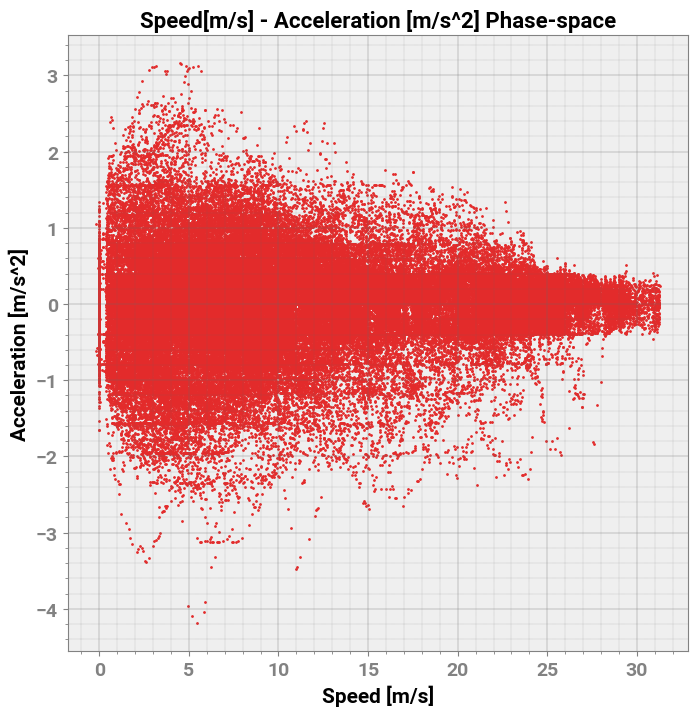

In [7]:
fig, ax = strym.create_fig(1)
fig.set_size_inches(8, 8)
ax[0].scatter(x = 'Speed', y = 'Accel', data = speed_accel, s = 1, color = "#E32b2b")
ax[0].set_xlabel('Speed [m/s]')
ax[0].set_ylabel('Acceleration [m/s^2]')
ax[0].set_title('Speed[m/s] - Acceleration [m/s^2] Phase-space')
plt.show()

In [16]:
dt_object = datetime.datetime.fromtimestamp(time.time())
dt = dt_object.strftime('%Y-%m-%d-%H-%M-%S-%f')
description = "_2020_03_05_Acceleration_Speed_Data"
fig.savefig(dt+ description + ".pdf", dpi = 300)
fig.savefig(dt+ description + ".png", dpi = 300)
pickle.dump(fig, open(dt+ description +".pickle", 'wb'))

In [17]:
variable_dictionary = {}
variable_dictionary['speed_accel'] = speed_accel.to_numpy()

In [18]:
sio.savemat(dt+"_2020_03_05_Acceleration_Speed_Data.mat", variable_dictionary)